We will be building on top of [this notebook](https://github.com/dipanjanS/adversarial-learning-robustness/blob/main/tutorials/attacks/02_1_targeted_pgd.ipynb). We will learn how to launch a targeted PGD-based attack on [EfficientNet](https://arxiv.org/pdf/1905.11946) and its [Noisy Student (NST)](https://arxiv.org/abs/1911.04252) variant. It will be clear that under the same hyperparameter configurations, they perform better than other networks like ResNet50. 

**Note**: EfficientNet models in `tf.keras.applications` take care of normalization as a part of in-model preprocessing. So, we don't need to apply any pixel scaling beforehand. 

## Initial setup and imports

In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.3.0


We first download a sample image which we will perturb in order to fool our pre-trained image classifier. We also download a dictionary that contains the mapping between the Imagenet dataset class labels and their ids.

In [2]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

## A few early constants

In [3]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

## Utility functions

Next we define a couple of utility functions that we will be using throughout the course of this notebook.

In [4]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels):
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)
    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

## Downloading the noisy student training weights and preparing them

In [5]:
!wget -q https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz

!wget -q https://raw.githubusercontent.com/yixingfu/tensorflow/updateweights/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --ckpt \
       noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0.h5

2020-10-23 16:10:12.119219: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-23 16:10:13.625656: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-23 16:10:13.677314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-23 16:10:13.677948: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2020-10-23 16:10:13.678003: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-23 16:10:13.944487: I tensorflow/stream_executor/platform/defaul

## Loading our first image and pre-trained models

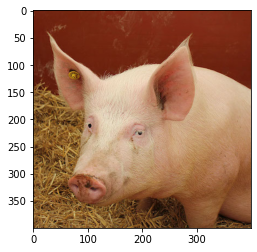

In [6]:
sample_image = show_image("pig.jpg")
preprocessed_image = preprocess_image(sample_image)
enb0 = tf.keras.applications.EfficientNetB0(weights="imagenet")
enb0_nst = tf.keras.applications.EfficientNetB0(weights="efficientnetb0.h5")

## Running inference with the pre-trained models

In [7]:
# Run inference EfficientNetB0 (ImageNet)
preds = enb0.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02395406', 'hog', 0.95161843), ('n02396427', 'wild_boar', 0.008885939), ('n03935335', 'piggy_bank', 0.000975785)]
Class idx: 341


In [8]:
# Run inference EfficientNetB0 (NST)
preds = enb0_nst.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

Predicted: [('n02395406', 'hog', 0.95926934), ('n02396427', 'wild_boar', 0.011101335), ('n03935335', 'piggy_bank', 0.00037483804)]
Class idx: 341


## Utility functions for adversarial attacks

In [9]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = image_tensor + delta
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true, target, model):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocessed_image)
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, true, target)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = image_tensor + delta_tensor
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=3)[0])

Note that the hyperparameters like learning rate, number of epochs were determined after empirical experiments and also by referring to [this tremendous tutorial](https://adversarial-ml-tutorial.org/introduction/).

## Launching a targeted attack!

Let's try to make our model believe that the hog is actually a `Lakeland_terrier`. Recall that the class index of hog in the ImageNet dataset is 341 and for Lakeland_terrier it's 189.

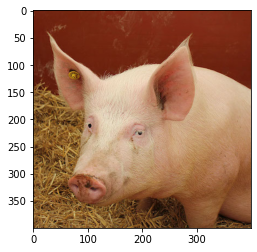

Prediction before adv.: [('n02395406', 'hog', 0.95161843), ('n02396427', 'wild_boar', 0.008885939), ('n03935335', 'piggy_bank', 0.000975785)]
0 10.832269
20 9.482447
40 8.303578
60 7.307212
80 6.4632807
100 5.7365913
120 5.098838
140 4.528514
160 4.010934
180 3.5373917
200 3.100786
220 2.6936336
240 2.3085117
260 1.937913
280 1.5741196
300 1.2097263
320 0.8382993
340 0.45216322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


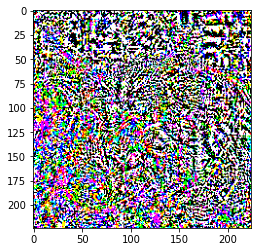

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


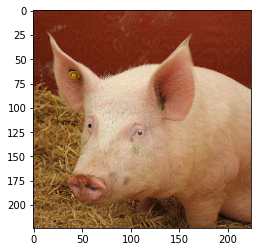

Prediction after adv.: [('n01883070', 'wombat', 0.052758213), ('n03935335', 'piggy_bank', 0.017097067), ('n02364673', 'guinea_pig', 0.014073901)]


In [10]:
# With Efficient + ImageNet pre-trained weights
perturb_image("pig.jpg", 341, 189, enb0)

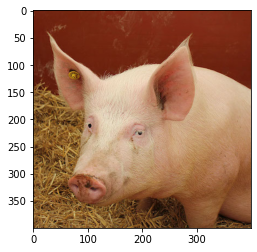

Prediction before adv.: [('n02395406', 'hog', 0.95926934), ('n02396427', 'wild_boar', 0.011101335), ('n03935335', 'piggy_bank', 0.00037483804)]
0 10.308752
20 8.912899
40 7.818784
60 6.932439
80 6.2171345
100 5.6579413
120 5.2059255
140 4.8156915
160 4.4611435
180 4.1322794
200 3.8288102
220 3.5451128
240 3.2785795
260 3.0266738
280 2.7859974
300 2.5544088
320 2.3312728
340 2.1180267


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


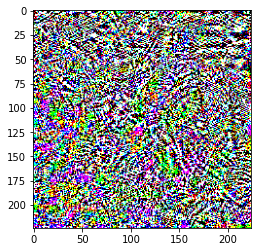

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


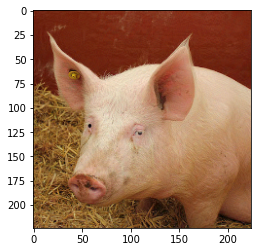

Prediction after adv.: [('n02395406', 'hog', 0.02181832), ('n02396427', 'wild_boar', 0.006920154), ('n02397096', 'warthog', 0.004987267)]


In [11]:
# With Efficient + Noisy Student Training weights
perturb_image("pig.jpg", 341, 189, enb0_nst)

We can see that under similar hyperparameter configurations we weren't able to target EfficientNet variants with adversarial perturbations.